In [1]:
import numpy as np
from tensor import Tensor
import nn
from tqdm import trange
from datasets import load_dataset

/home/minhalvp/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
mnist = load_dataset('mnist')

def convert_to_np(example):
    example['np_image'] = np.asarray(example['image'])
    return example
mnist = mnist.map(convert_to_np)

# Convert X_train, Y_train, X_test, and Y_test to CuPy arrays
X_train, Y_train = np.asarray(mnist['train']['np_image']), np.asarray(mnist['train']['label'])
X_test, Y_test = np.asarray(mnist['test']['np_image']), np.asarray(mnist['test']['label'])

lr = 0.01
BS = 64

model = nn.Sequential(
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
    nn.LogSoftmax()
)

In [3]:
losses, accuracies = [], []
for i in (t := trange(1000)):
  samp = np.random.randint(0, X_train.shape[0], size=(BS))  
  x = Tensor(X_train[samp].reshape((-1, 28*28)))
  Y = Y_train[samp]
  y = np.zeros((len(samp),10), np.float32)
  y[range(y.shape[0]),Y] = -1.0
  y = Tensor(y)
  output = model.forward(x)
  x = output.mul(y)
  x = x.mean()
  x.backward()
  
  loss = x.data
  cat = np.argmax(output.data, axis=1)
  accuracy = (cat == Y).mean()
  losses.append(loss)
  accuracies.append(accuracy)
  t.set_description(f"loss {loss} accuracy {accuracy}")
  # SGD
  model.step(lr=lr, optimizer=nn.SGD)


loss [0.00648034] accuracy 0.984375: 100%|██████████| 1000/1000 [00:05<00:00, 180.81it/s]


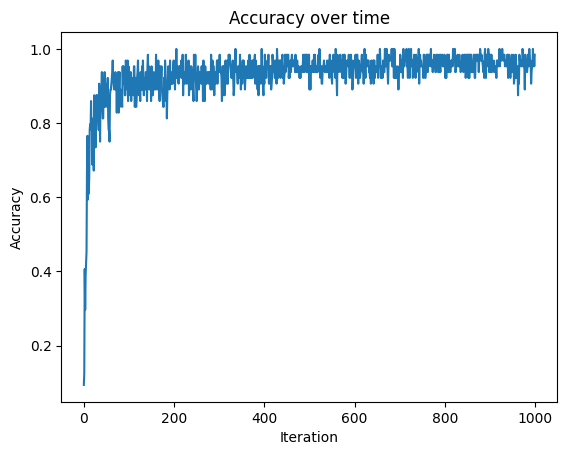

In [4]:
import matplotlib.pyplot as plt

plt.plot(accuracies)
plt.title('Accuracy over time')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.show()

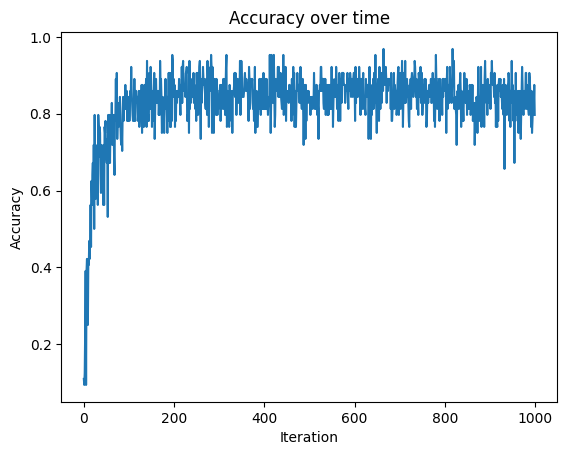

In [9]:
import matplotlib.pyplot as plt

plt.plot(accuracies)
plt.title('Accuracy over time')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.show()


In [1]:
modeldict = {}

for i, layer in enumerate(model.layers):
    # check if layer.params exists
    name = layer.__class__.__name__
    if hasattr(layer, 'params'):
        # name of class of layer
        modeldict[f"{name}{i}"] = layer.params
    else:
        modeldict[f"{name}{i}"] = name



NameError: name 'model' is not defined

In [30]:
import h5py

with h5py.File('model.h5', 'w') as f:
    for key, value in modeldict.items():
        print
        if isinstance(value, dict):
            for k, v in value.items():
                f.create_dataset(f"{key}/{k}", data=v.data)
        else:
            f.create_dataset(key, data=value)


In [ ]:
for i in range(len(X_test)):
    input = Tensor(np.array(X_test[i]).reshape((-1, 28*28))).to('cuda')
    output = model.forward(input)
    cat = np.argmax(output.data, axis=1)
    accuracy = (cat == Y_test[i]).mean()
    accuracies.append(accuracy)

In [ ]:
import cupy as cp

accuracies = cp.array(accuracies)
print(f"Accuracy: {accuracies.mean()}")

In [ ]:
model.layers[0].params['LinearW'].data

In [ ]:
# Use the test set to evaluate the model
def forward(x):
  x = l1(x)
  x.data = np.maximum(x.data, 0)
  x = l2(x)
  return x.data


def numpy_eval():
  x = Tensor(X_test.reshape((-1, 28*28)))
  print(x.data.shape)
  Y_test_preds_out = forward(x)
  Y_test_preds = np.argmax(Y_test_preds_out, axis=1)
  return (Y_test == Y_test_preds).mean()

print(f"test set accuracy is {numpy_eval()}")


In [ ]:
from datasets import load_dataset
import numpy as np

mnist = load_dataset('mnist')

def convert_to_np(example):
    example['np_image'] = np.array(example['image']).reshape((-1, 28*28))
    label = np.zeros((10), np.float32)
    label[example['label']] = -1.0
    example['np_label'] = label
    return example
mnist = mnist.map(convert_to_np)

In [ ]:
import nn
from tensor import Tensor
import numpy as np

model = nn.Sequential(
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
    nn.LogSoftmax()
)

In [ ]:
x = np.random.randn(64, 784)
x = Tensor(x)

In [ ]:
y = model.forward(x)
model.step(1)
model.layers[0].params['LinearW'].data

In [ ]:
from tensor import Tensor, Dot
import numpy as np
a = Tensor(np.array([[1,2,3],[4,5,6]]))
b = Tensor(np.array([[6,5,4], [3,2,1]]))

c = a.mse(b)
c = c.mean()
c.backward()
print(a.grad)

In [ ]:
import torch

a = torch.tensor([[1,2,3],[4,5,6]], dtype=torch.float32, requires_grad=True)
b = torch.tensor([[6,5,4], [3,2,1]], dtype=torch.float32)

c = torch.nn.functional.mse_loss(a, b, reduction="mean")
print(c)
c.backward()

print(a.grad)

In [1]:
import torch

a = torch.tensor([[1,2,3],[4,5,6]], dtype=torch.float32, requires_grad=True)
b = torch.tensor([[6,5,4], [3,2,1]], dtype=torch.float32)

c = a + b
d = c.mean()
d.backward()
